# Logistic Regression - Newton Raphson
#### by Andrew Rothman

Here we will explore Logistic where we will: <br>
* Specify the statistical model and it's functional form
* Using the Iris dataset as a motivating example, we will recover estimates of the parameters of the model we specified using the iterative numerical algorithm Newton Rhapson.

## 1) Model Specification
### Variables & Dimensions
Let us begin by specifying our variable relations and matrix dimensions:

$\begin{align}
Y
\end{align}$ ~ n iid Bernouli RVs

$$
\begin{align}
\hat{Y} = A = \sigma(Z) = \frac{1}{1+e^{-Z}} \\
Z = X \hat{\beta} \\
\end{align}
$$

$\begin{aligned}
n=
\end{aligned}$ number of observations

$\begin{aligned}
p=
\end{aligned}$ number of parameters

Note, that in this formulation we are imbedding the intercept term into the Design and Parameter matrices

$$
\begin{align}
Y, A, Z : n\times 1 \\
X : n\times (p+1) \\
\hat{\beta} : (p+1)\times 1 \\
\end{align}
$$

### Cost Function (Negative Log Likelihood)
$$
\begin{align}
\mathcal{L}(A|Y) = \prod_{i=1}^n A^Y (1-A)^{1-Y} \\
-\ln (\mathcal{L}(A|Y)) = J = \sum_{i=1}^n -\ln (A^Y (1-A)^{1-Y}) \\
J = \sum_{i=1}^n -Y\ln(A) - (1-Y)\ln(1-A) \\
\end{align}
$$

in vectorized form, this reduces to:
$$
\begin{align}
J = -Y^{T}\ln(A) - (1-Y)^{T}\ln(1-A)
\end{align}
$$

Note that:
$$
\begin{align}
\ln(A) = \ln(\frac{1}{1+e^{-Z}}) = \ln(1) - \ln(1+e^{-Z}) = - \ln(1+e^{-Z}) \\
\frac{\partial \ln(A)}{\partial Z} = -(\frac{1}{1+e^{-Z}})(e^{-Z})(-1) = \frac{e^{-Z}}{1+e^{-Z}} =  \frac{1+ e^{-Z} -1}{1+e^{-Z}} =  1 -\frac{1}{1+e^{-Z}} = (1-A)   \\
\frac{\partial Z}{\partial \hat{\beta}} = X \\
\frac{\partial \ln(A)}{\partial \hat{\beta}} = X^{T}(1-A)
\end{align}
$$

And also note that:
$$
\begin{align}
\ln(1-A) = \ln(1 - \frac{1}{1+e^{-Z}}) = \ln(\frac{e^{-Z}}{1+e^{-Z}}) = \ln(e^{-Z}) - \ln(1+e^{-Z}) = -Z - \ln(1+e^{-Z}) \\
\frac{\partial \ln(1-A)}{\partial Z} = -1 + (1-A) = -A \\
\frac{\partial \ln(1-A)}{\partial \hat{\beta}} = -X^{T}A \\
\end{align}
$$

Therefore, we have in vectorized form:
$$
\begin{align}
J = -Y^{T}\ln(A) - (1-Y)^{T}\ln(1-A) \\
\frac{\partial J}{\partial \hat{\beta}} = X^{T}(A-Y) \\
\end{align}
$$

And:
$$
\begin{align}
\frac{\partial J}{\partial \hat{\beta}} = X^{T}(A-Y) = X^{T}A - X^{T}Y = X^{T}\sigma(Z) - X^{T}Y \\
\frac{\partial^{2} J}{\partial^{2} \hat{\beta}} = \sigma(Z)(1-\sigma(Z))^{T}*X^{T}X \\
\end{align}
$$

### Newton Rhapson Algorithm

$$
\begin{align}
\hat{\beta}_{i+1} = \hat{\beta}_i - (\frac{\partial^{2} J}{\partial^{2} \hat{\beta}_i})^{-1}\frac{\partial J}{\partial \hat{\beta}_i}
\end{align}
$$



## 2) Motivating Example with the "Iris" Dataset
We will show the above closed form solution in action with a motivating example. We will use the Iris Dataset to do so by:
* Using "Sepal Length" as our outcome of interest, with all remaining variables as covariates in the regression model
 * The variable "Sepal Length" has been reparameterized to a [0,1] variable with "Sepal Length">=5.8 set to "1"
 * Note, the variable "Species" is reparameterized as "one-hot" coding, with the category "virginica" set as the reference category

In [1]:
######################
## import libraries ##
######################
import numpy as np
import pandas as pd
from sklearn import datasets
import statsmodels.formula.api as sm
from statsmodels.genmod.families import Binomial
from numpy.linalg import inv
import matplotlib.pyplot as plt 

In [2]:
###################################
## import and clean iris dataset ##
###################################
iris = datasets.load_iris()
LR_df = pd.DataFrame()
LR_df['S_Length'] = iris['data'][:,0]
LR_df['Intercept']=np.full(iris['data'].shape[0], 1)
LR_df['S_Width'] = iris['data'][:,1]
LR_df['P_Length'] = iris['data'][:,2]
LR_df['P_Width'] = iris['data'][:,3]
LR_df['Species'] = iris['target']
LR_df['Species'] = LR_df['Species'].apply(str)
LR_df.loc[LR_df['Species']==str(0), "Species"] = str(iris['target_names'][0])
LR_df.loc[LR_df['Species']==str(1), "Species"] = str(iris['target_names'][1])
LR_df.loc[LR_df['Species']==str(2), "Species"] = str(iris['target_names'][2])
LR_df['Species_setosa']=0
LR_df.loc[LR_df['Species']=='setosa', 'Species_setosa']=1
LR_df['Species_versicolor']=0
LR_df.loc[LR_df['Species']=='versicolor', 'Species_versicolor']=1
LR_df.loc[LR_df['S_Length']<5.8, 'S_Length'] = 0
LR_df.loc[LR_df['S_Length']>=5.8, 'S_Length'] = 1
LR_df = LR_df.drop('Species', axis=1)
LR_df.describe()

,S_Length,Intercept,S_Width,P_Length,P_Width,Species_setosa,Species_versicolor
count,150.000000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.513333,1.0,3.054000,3.758667,1.198667,0.333333,0.333333
std,0.501497,0.0,0.433594,1.764420,0.763161,0.472984,0.472984
min,0.000000,1.0,2.000000,1.000000,0.100000,0.000000,0.000000
25%,0.000000,1.0,2.800000,1.600000,0.300000,0.000000,0.000000
50%,1.000000,1.0,3.000000,4.350000,1.300000,0.000000,0.000000
75%,1.000000,1.0,3.300000,5.100000,1.800000,1.000000,1.000000
max,1.000000,1.0,4.400000,6.900000,2.500000,1.000000,1.000000


In [3]:
#######################################
## creat arrays for Gradient Descent ##
#######################################
Y = np.array(LR_df['S_Length']).reshape((len(LR_df['S_Length']), 1))
X = np.array(LR_df[['Intercept', 'S_Width', 'P_Length', 'P_Width', 'Species_setosa', 'Species_versicolor']])

## 3) Compute Solution

In [4]:
#################################
## initialize parameter matrix ##
#################################
k = X.shape[1]
np.random.seed(10815657)
nudge=0.1
Beta = np.random.uniform(low=-1*nudge, high=1*nudge, size=k).reshape(k, 1)
Z = np.dot(X, Beta)
A = 1 / (1+np.exp(-Z))

In [5]:
####################
## Newton Rhapson ##
####################
m = 10000
J = pd.DataFrame()
J['iterative_step'] = range(0,m+1)
J['cost'] = np.full(m+1, None)
J.loc[0, 'cost'] = np.asscalar(-np.dot(Y.T, np.log(A)) -np.dot((1-Y.T), np.log(1-A)))                             

for i in range(1, m+1):    
    J_partial_Beta = np.dot(X.T, (A-Y))
    J2_partial_Beta2 = np.dot(X.T, X)*np.dot(A.T,(1-A))
    Beta = Beta - np.dot(inv(J2_partial_Beta2), J_partial_Beta)
    Z = np.dot(X, Beta)
    A = 1 / (1+np.exp(-Z))
    J.loc[i, 'cost'] = np.asscalar(-np.dot(Y.T, np.log(A)) -np.dot((1-Y.T), np.log(1-A))) 
    del J_partial_Beta 

array([[-21.69161855],
       [  1.82823841],
       [  4.74450613],
       [ -2.69484012],
       [  4.72884521],
       [  0.35971315]])

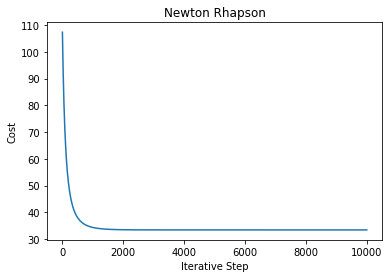

In [6]:
plt.plot(J['iterative_step'], J['cost'])
plt.title('Newton Rhapson') 
plt.xlabel('Iterative Step') 
plt.ylabel('Cost') 
Beta

In [7]:
print(Beta)

[[-21.69161855]
 [  1.82823841]
 [  4.74450613]
 [ -2.69484012]
 [  4.72884521]
 [  0.35971315]]


Let's compare this solution to that provided by the Logistic model provided in the "statsmodels" package

In [8]:
## built in package
results = sm.glm(formula="S_Length ~ S_Width + P_Length + P_Width + Species_setosa + Species_versicolor", data=LR_df, family=Binomial()).fit()
print(results.params)

Intercept            -21.691740
S_Width                1.828247
P_Length               4.744541
P_Width               -2.694876
Species_setosa         4.728879
Species_versicolor     0.359710
dtype: float64
